In [5]:
#All Libraries used
import matplotlib.pyplot as plt
import numpy as np
import pandas._libs.testing as _testing
import pandas as pd


In [6]:
#Import Dataset
df = pd.read_csv('loan_default_prediction.csv')
print(df.shape)

(87500, 30)


In [7]:
#drop
vdrop=['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status','Claim_Type']
df=df.drop(vdrop,axis=1)
df.shape

(87500, 18)

In [8]:
def romanToInt(i):
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    j = 0
    num = 0
    while j < len(i):
        if j+1<len(i) and i[j:j+2] in roman:
            num+=roman[i[j:j+2]]
            j+=2
        else:

            num+=roman[i[j]]
            j+=1
    return num

In [9]:
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','')).astype(int)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#ver resultado
#df.head()

In [10]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 18)

In [11]:
#df.describe()
df.head(5)

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Due_Fee,Default
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3,31216.05,debt consolidation,0.0,0
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5,11660.49,debt consolidation,0.0,0
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5,5637.87,major purchase,0.0,0
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3,15607.17,major purchase,0.0,1
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5,27472.86,debt consolidation,0.0,0


In [12]:
v_num_cont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate',
            'Present_Balance','Due_Fee','Unpaid_Amount']
v_num_disc=['Unpaid_2_years','Already_Defaulted','Account_Open','Duration']
v_cat_ord=['Home_Status','State','Reason','GGGrade']

In [13]:
#fazer histograma das categoricas e value_counts (verificar se há categorias de pouca relevancia)
for i in v_cat_ord:
    print(df[i].value_counts())


MORTGAGE    39077
RENT        30853
OWN          7436
OTHER           6
NONE            4
Name: Home_Status, dtype: int64
California    11194
Newyork        6414
TX             6307
Florida        5149
IL             3091
NewJersey      2877
PA             2797
Ohio           2602
GA             2572
VA             2251
NC             2230
MI             1995
Maryland       1857
AZ             1797
MA             1764
CO             1685
WA             1627
MN             1493
IN             1276
MO             1253
TN             1184
CT             1172
NV             1039
AL              999
WI              990
OR              929
LA              908
SC              888
KY              728
KS              722
OK              676
AR              564
UT              556
NM              424
HI              423
MS              370
NH              365
WV              344
RI              337
MT              225
DC              206
DE              205
AK              198
WY              16

In [14]:
from scipy import stats
display(df.shape)
df=df[(df['Home_Status']!='OTHER')&(df['Home_Status']!='NONE')]
df=df[(np.abs(stats.zscore(df[v_num_cont])) < 3).all(axis=1)]
df.shape


ImportError: cannot import name 'int' from 'numpy' (/home/goncalo/anaconda3/lib/python3.8/site-packages/numpy/__init__.py)

In [15]:
(df['Default']==1).sum()

14629

In [13]:
defaulted = df[df['Default']==1].sample(n=5000, random_state=101)
notdefault = df[df['Default']==0].sample(n=5000, random_state=101)
df = pd.concat([defaulted,notdefault],axis=0)
df.shape
df = df.reset_index()
display(df.index)

RangeIndex(start=0, stop=10000, step=1)

# Train vs test sample: standard and cross-validation

In [95]:
# Split the data into features (X) and labels (y)
X = df[v_num_cont]
y = df['Default']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#implement cross validation
from sklearn.model_selection import KFold
#kfold = KFold(n_splits=5,shuffle=True)
#for train_index, test_index in kfold.split(X):
#    print("Train index:", train_index, "Test index:", test_index)
#    X_train, X_test = X.loc[train_index], X.loc[test_index]
#    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Pipelines

In [150]:
#make the input data as "normal" as possible
#start by decreasing the skewness and assessing which are asymmetric
def skew_df(df):
    from scipy.stats import skewtest
    skewness, p_value = skewtest(df)
    dskew=pd.DataFrame(np.round(np.vstack((skewness.T,p_value.T)),2),columns=df.columns,
                    index=['skewness', 'p_value'])
    return(dskew)

dskew=skew_df(df[v_num_cont])
display(dskew)
v_skew=list(dskew.columns[dskew.loc['p_value']<0.05])
v_sym=list(set(X_train.columns) - set(v_skew))


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount
skewness,15.38,-7.9,42.65,25.65,-0.48,-7.74,38.59,1.00,49.36
p_value,0.00,0.0,0.00,0.00,0.63,0.00,0.00,0.32,0.00


In [185]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the transformations to apply to the column
transformer = ColumnTransformer([
    #('scale', PowerTransformer(), ['col1']),  # Scale the numeric column
    ('yeoj', PowerTransformer(), v_skew),
    ('std', StandardScaler(), v_sym)
])

pipeline= Pipeline([
    ('ct', transformer),
    #('to_df', pd.DataFrame, {'columns': v_skew+v_sym})
    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = (v_skew + v_sym))))
])

# Transform the data
pfit = pipeline.fit(X_train)
X_train_transf = pipeline.transform(X_train)
X_test_transf = pipeline.transform(X_test)

#display(X_train)
#print((v_skew+v_sym))
#X_train_transformed= pd.DataFrame(df_transformed,
                                 # columns=(v_skew+v_sym),index=X_train.index)
#X_train_transformed.describe()
display(X_train_transf.head(3))
display(X_test_transf.head(3))

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,Due_Fee,Interest_Charged
0,-0.973717,1.064834,0.300292,-0.575944,1.584279,-1.348118,0.085311,0.0,-0.950017
1,-0.256935,0.014724,1.402172,1.222470,-1.584856,1.251379,-0.350859,0.0,-1.362923
2,-0.911331,0.286656,1.086286,0.765449,-0.828236,2.003421,0.852903,0.0,-0.438995


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,Due_Fee,Interest_Charged
0,1.397869,1.064834,0.644443,1.627011,0.729540,1.255159,1.146483,0.0,1.012306
1,-0.456915,-1.514876,0.832043,0.278993,-1.576200,0.907219,-1.456315,0.0,1.527416
2,-1.030845,-0.554921,0.809456,-0.575944,1.205803,-0.740800,-0.746265,0.0,0.863088


# Models

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LogisticRegression()
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

Best parameters: {'C': 0.001}
Best score: 0.73


In [205]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LinearSVC(loss='hinge')
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

Best parameters: {'C': 10}
Best score: 0.74


/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/goncalo/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [194]:
from sklearn.tree import DecisionTreeClassifier
tree_clf=DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train_transf,y_train)
y_pred=tree_clf.predict(X_test)

DecisionTreeClassifier(max_depth=2)

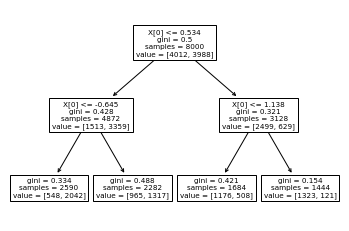

In [197]:
from sklearn.tree import plot_tree
plot_tree(tree_clf);

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
est=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
est.fit(X_train)
Xt_train=est.transform(X_train_transf)
Xt_test=est.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnNB=MultinomialNB()
mnNB.fit(Xt_train,y_train)
y_pred=mnNB.predict(Xt_test)

from sklearn.naive_bayes import GaussianNB
gNB=MultinomialNB()
gNB.fit(X_train_transf,y_train)
y_pred=gNB.predict(X_test)

In [198]:
from sklearn.ensemble import RandomForestClassifier
rf_Model=RandomForestClassifier()
rf_Model.fit(X_train_transf,y_train)
y_pred=rf_Model.predict(X_test_transf)

In [201]:
#number of trees
n_estimators=[int(x) for x in np.linspace(10,100,4)]
#number of splits to consider at every split
max_features=['auto','sqrt']
#maximum number of levels
max_depth=[2,4]
#min of samples required to split a node
min_samples_split=[2,5]
#min samples required at each leaf node
min_samples_leaf=[1,2]
#method of selecting samples for training each tree
bootstrap=[True,False]

param_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
            'bootstrap':bootstrap
}

In [203]:
from sklearn.model_selection import GridSearchCV
rf_Grid=GridSearchCV(rf_Model,param_grid,cv=5)
rf_Grid.fit(X_train_transf,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 40, 70, 100]})

In [210]:

y_pred=rf_Grid.predict(X_test)
rf_Grid.best_score_

0.73475

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
y_pred=knn_clf.predict(X_test)

In [215]:
import xgboost as xgb
# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # binary classification
    'max_depth': 5,  # maximum depth of the tree
    'learning_rate': 0.1,  # learning rate
    'n_estimators': 100  # number of trees to be built
}

# Create the XGBoost model
model = xgb.XGBClassifier(**params)

# Train the model
model.fit(X_train_transf, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_transf)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       988
           1       0.71      0.78      0.74      1012

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [212]:
import numpy as np
import tensorflow as tf

# Load the data
X, y = load_data()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert the labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),  # hidden layer
    tf.keras.layers.Dense(y_train_one_hot.shape[1], activation='softmax')  # output layer
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32)

# Predict the labels for the test set
y_pred_one_hot = model.predict(X_test)

# Convert the one-hot encoding back to labels
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Evaluate the model using accuracy
accuracy = sum(y_pred == y_test) / len(y_test)
print(f'Accuracy: {accuracy:.2f}')

     |████████████████████████████████| 193.6 MB 94 kB/s  eta 0:00:012  |▏                               | 1.0 MB 1.8 MB/s eta 0:01:50     |█▊                              | 10.2 MB 5.3 MB/s eta 0:00:35     |█▉                              | 11.0 MB 1.7 MB/s eta 0:01:47     |███████                         | 43.0 MB 4.6 MB/s eta 0:00:34     |██████████████████████████▌     | 160.1 MB 1.8 MB/s eta 0:00:19     |███████████████████████████▊    | 167.6 MB 129 kB/s eta 0:03:21
Note: you may need to restart the kernel to use updated packages.


# Avaliação de performance

In [199]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       988
           1       0.71      0.76      0.74      1012

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
#print(accuracy_score(y_test,y_pred))
#print(precision_score(y_test,y_pred))
#print(recall_score(y_test,y_pred))
#print(f1_score(y_test,y_pred))

In [119]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

[[736 252]
 [299 713]]
0.7247423629002575


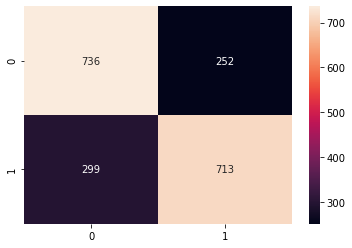

In [126]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g');

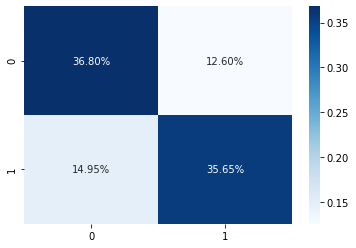

In [125]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues');

In [206]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.7315
0.734915924826904
0.7341897233201581
0.7345526445872467


In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC - TPR vs FPR')
    
plot_roc_curve(fpr,tpr)

# Feature selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Use Recursive Feature Elimination (RFE) to select the top 2 features
rfe = RFE(model, 2)
rfe.fit(X_train, y_train)

# Transform the training and test data using the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test data
predictions = model.predict(X_test_selected)

# Print the accuracy
print(accuracy_score(y_test, predictions))

############################################################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be an empty list
selected_features = []

# Set the maximum number of features to select
max_features = 2

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
for i in range(1, len(feature_indices) + 1):
    for combination in combinations(feature_indices, i):
        # Select the current combination of features
        X_selected = X[:, combination]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
        if score > best_score:
            best_score = score
            selected_features = combination

# Print the selected features
print(selected_features)
##########################################
#BACKWARD

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be all the features
selected_features = feature_indices

# Set the minimum number of features to select
min_features = 1

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
while len(selected_features) > min_features:
    scores = []
    for i in range(len(selected_features)):
        # Select the current combination of features
        X_selected = X[:, selected_features]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # Add the score for the current combination of features
        scores.append(score)
    
    # Find the index of the feature with the lowest score
    worst_feature_index = np.argmin(scores)
    
    # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
    if scores[worst_feature_index] > best_score:
        best_score = scores[worst_feature_index]
        selected_features = selected_features[:worst_feature_index] + selected_features[worst_feature_index + 1:]
    else:
        # If the current combination of features has a lower cross-validated score than the best score, stop the search
        break

# Print the selected features
print(selected_features)

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'StandardScaler' is not defined

In [15]:
# Fit different models and evaluate their performance
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__}: {accuracy:.2f}")

NameError: name 'LogisticRegression' is not defined

In [ ]:
#STACKING
# Define the base models
base_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

# Define the second-level model
meta_model = LogisticRegression()

# Define the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Evaluate the model
accuracy = stacking_model.score(X_test, y_test)
print("Accuracy:", accuracy)


In [ ]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

In [4]:
import numpy as np



Train index: [0 1 2 3 4 6 7 9] Test index: [5 8]
Train index: [0 1 2 3 4 5 6 8] Test index: [7 9]
Train index: [0 2 4 5 6 7 8 9] Test index: [1 3]
Train index: [1 3 4 5 6 7 8 9] Test index: [0 2]
Train index: [0 1 2 3 5 7 8 9] Test index: [4 6]


In [ ]:
#xgboost
from xgboost import XGBClassifier

# Create the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

In [ ]:
#CLUSTERING AS PREPROCESSING DATA INTO CLASSIFICATION PROBLEM
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use KMeans to cluster the training data into 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

# Add the cluster labels as a new feature in the training data
X_train_clustered = np.concatenate((X_train, kmeans.labels_.reshape(-1, 1)), axis=1)

# Create a Random Forest classifier and train it on the clustered data
model = RandomForestClassifier()
model.fit(X_train_clustered, y_train)

# Add the cluster labels as a new feature in the test data
X_test_clustered = np.concatenate((X_test, kmeans.predict(X_test).reshape(-1, 1)), axis=1)

# Make predictions on the test data
predictions = model.predict(X_test_clustered)

One way to pick the optimal number of clusters for a clustering algorithm is to use an evaluation metric that compares the quality of different clusterings. There are many such metrics available, such as the silhouette score, the Calinski-Harabasz index, and the Davies-Bouldin index.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]

# Try clustering the data with different numbers of clusters
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)

    # Calculate the silhouette score for this number of clusters
    score = silhouette_score(X, cluster_labels)
    print("Number of clusters:", n_clusters, "Silhouette score:", score)
    
    ###################
#PROF DOC

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
("kmeans", KMeans(n_clusters=50)),
("log_reg", LogisticRegression()),
])
pipeline.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
Let’s look at the best value for k and the performance of the resulting pipeline:
>>> grid_clf.best_params_
{'kmeans__n_clusters': 99}
>>> grid_clf.score(X_test, y_test)
0.9822222222222222

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]

# Create a PCA object and fit it to the data
pca = PCA()
pca.fit(X)

# Plot the explained variance ratio as a function of the number of dimensions
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance ratio')
plt.show()

In [5]:
# Choose the optimal number of dimensions based on the explained variance ratio
n_dimensions = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

# Transform the training and test data using the chosen number of dimensions
X_train_transformed = pca.transform(X_train)[:, :n_dimensions]
X_test_transformed = pca.transform(X_test)[:, :n_dimensions]

NameError: name 'pca' is not defined

There are many different types of clustering algorithms, but some of the most common ones include:

    K-means clustering: This is a centroid-based algorithm that divides a dataset into a predefined number of clusters by minimizing the sum of squared distances between the points and the cluster centroids.

    Hierarchical clustering: This is an agglomerative algorithm that builds a hierarchy of clusters by iteratively merging the closest pairs of clusters.

    DBSCAN: This is a density-based algorithm that divides a dataset into clusters based on the density of the points. It is able to identify clusters of different shapes and sizes and can handle noisy or outlier points.

    Expectation-maximization (EM): This is a probabilistic algorithm that estimates the underlying distribution of the data and uses it to identify clusters.

    Affinity propagation: This is a message-passing algorithm that identifies clusters by exchanging messages between pairs of points until a consensus is reached.